In [16]:
import datetime as dt
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import yfinance as yf
import matplotlib.pyplot as plt

pyo.init_notebook_mode(connected=True)
pd.options.plotting.backend = 'plotly'

In [5]:
end = dt.datetime.now()
start = dt.datetime(2017,1,1)

yf.pdr_override()

df = pdr.get_data_yahoo(['TSLA', 'GOOGL','ABC'], start, end)

Close = df.Close
Close.head()

[*********************100%***********************]  3 of 3 completed


,ABC,GOOGL,TSLA
Date,,,
2017-01-03,82.610001,40.400501,14.466000
2017-01-04,84.660004,40.388500,15.132667
2017-01-05,83.680000,40.651001,15.116667
2017-01-06,84.800003,41.260502,15.267333
2017-01-09,85.480003,41.359001,15.418667


In [6]:
# Computing log returns

log_returns = np.log(df.Close/df.Close.shift(1)).dropna()
log_returns

,ABC,GOOGL,TSLA
Date,,,
2017-01-04,0.024513,-0.000297,0.045055
2017-01-05,-0.011643,0.006478,-0.001058
2017-01-06,0.013296,0.014882,0.009918
2017-01-09,0.007987,0.002384,0.009863
2017-01-10,-0.007633,-0.001415,-0.006115
...,...,...,...
2023-07-24,-0.005937,0.012503,0.034176
2023-07-25,0.002296,0.005580,-0.014149
2023-07-26,-0.022024,0.056162,-0.003512


In [7]:
# Computing standard deviations

daily_std = log_returns.std()
annualized_std = daily_std * np.sqrt(252)
annualized_std

ABC      0.284226
GOOGL    0.297088
TSLA     0.612509
dtype: float64

## Histogram of log returns with their annulized volatilties

In [10]:
fig = make_subplots(rows=2, cols=2)

trace0 = go.Histogram(x=log_returns['TSLA'], name='TSLA')
trace1 = go.Histogram(x=log_returns['GOOGL'], name='GOOGL')
trace2 = go.Histogram(x=log_returns['ABC'], name='ABC')


fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)

fig.update_layout(autosize = False, width=700, height=600, title='Frequency of log returns',
                  xaxis=dict(title='TSLA Annualized Volatility: ' + str(np.round(annualized_std['TSLA']*100, 1))),
                  xaxis2=dict(title='GOOGL Annualized Volatility: ' + str(np.round(annualized_std['GOOGL']*100, 1))),
                  xaxis3=dict(title='ABC Annualized Volatility: ' + str(np.round(annualized_std['ABC']*100, 1))))

fig.show()


## Trailing Volatility over time

Another way to visualise volatility (as opposed to annulized or daily single figure):

    - just plotting everyday's std


In [12]:
LOOKBACK_PERIOD = 60
volatility = log_returns.rolling(window=LOOKBACK_PERIOD).std()*np.sqrt(LOOKBACK_PERIOD)

volatility.plot()

### It is nice to compare this to the stock price:

In [42]:
Close.plot()

# Sharpe Ratio

A measure for calculating risk-adjusted return. The Sharpe ratio is the average return earned in excess of the risk-free rate per unit of volatility.

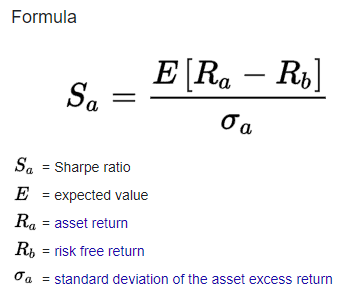

Basically; average return over time / units of volatility over time

In [46]:
# risk free rate
Rf = 0.01/252  

# Sharpe ratio - rolling over time
sharpe_ratio = (log_returns.rolling(window=LOOKBACK_PERIOD).mean() - Rf) *LOOKBACK_PERIOD/volatility 
# (returns - daily rff) * lookback / volatility



We need to multiply by

       lookback * 1 / volatility
   
because dividing by volatility dataframe, we have specified that many lookback period to calculate std.

In [47]:
sharpe_ratio.plot()

This is very helpful in understanding how the mean and volatility change over time. More useful to have rolling ratio than single figure over one period.

# Sortino Ratio

## Similar to Sharpe Ratio, but instead of using all observations to calculate std, the Sortino only considers harmful variance

In [59]:
# Start by taking only negative volatilties
sortino_vol = log_returns[log_returns<0].rolling(window=LOOKBACK_PERIOD, center=True, min_periods=4).std()*np.sqrt(LOOKBACK_PERIOD)

# Same as before
sortino_ratio = (log_returns.rolling(window=LOOKBACK_PERIOD).mean() - Rf) *LOOKBACK_PERIOD/sortino_vol 

sortino_vol.plot()

In [60]:
sortino_ratio.plot()